# **1.LOAD DATASET**

The following libraries are required and imported below.

In [14]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


In [15]:
# === General utilities ===
import pandas as pd
import numpy as np

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots

# === Preprocessing ===
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# === Modeling - Traditional ML ===
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# === Model evaluation ===
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)

# === Unsupervised Learning ===
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    adjusted_rand_score, silhouette_score,
    normalized_mutual_info_score
)


This notebook works with a pre-cleaned, standardized dataset in tabular format.

**Note**: Upload your file (`ET_EmoAgg_Youth_Tab.csv`) to the current Colab session and make sure the `file_path` matches its name.

Expected format: a CSV file with features and aggression labels for each subject.


In [17]:
file_path = "ET_EmoAgg_Youth_Tab_.csv"  # Replace with your actual file name if different
df = pd.read_csv(file_path)

print("File loaded successfully. Shape:", df.shape)
df.head()


File loaded successfully. Shape: (3776, 12)


,media_id,media_name,aoi_id,aoi_name,user_id,aggressive,user_gender,time_to_first_view_sec,time_viewed_sec,time_viewed_percent,fixations,revisits
0,1,2,2,positive_2,6,1,F,1.441,166.000,5.542,1.0,0
1,1,2,3,negative_2,6,1,F,0.000,512.000,17.053,3.0,1
2,1,2,2,positive_2,13,1,F,416.000,1.035,34.489,6.0,2
3,1,2,3,negative_2,13,1,F,610.000,812.000,27.067,4.0,1
4,1,2,2,positive_2,3,1,M,83.000,1.579,52.637,6.0,1


# **2. Data preprocessing**

In this section, we prepare the cleaned eye-tracking dataset for modeling. The steps include:

- Identifying categorical and numerical features
- Encoding categorical variables (media_name, aoi_name, user_gender)
- Removing neutral class samples
- Scaling selected numerical features


In [18]:
# Display categorical and numerical columns
print("Categorical columns:")
print(df.select_dtypes(include=["object", "category"]).columns.tolist())

print("\nNumerical columns:")
print(df.select_dtypes(include=["int64", "float64"]).columns.tolist())



Categorical columns:
['aoi_name', 'user_gender']

Numerical columns:
['media_id', 'media_name', 'aoi_id', 'user_id', 'aggressive', 'time_to_first_view_sec', 'time_viewed_sec', 'time_viewed_percent', 'fixations', 'revisits']


In [19]:
# Create a copy of the original DataFrame to encode
df_encoded = df.copy()

# Initialize label encoders
le_media = LabelEncoder()
le_aoi = LabelEncoder()
le_gender = LabelEncoder()

# Apply label encoding to categorical features
df_encoded["media_name"] = le_media.fit_transform(df_encoded["media_name"])
df_encoded["aoi_name"] = le_aoi.fit_transform(df_encoded["aoi_name"])
df_encoded["user_gender"] = le_gender.fit_transform(df_encoded["user_gender"])

# Preview the encoded DataFrame
df_encoded.head()




,media_id,media_name,aoi_id,aoi_name,user_id,aggressive,user_gender,time_to_first_view_sec,time_viewed_sec,time_viewed_percent,fixations,revisits
0,1,1,2,25,6,1,0,1.441,166.000,5.542,1.0,0
1,1,1,3,9,6,1,0,0.000,512.000,17.053,3.0,1
2,1,1,2,25,13,1,0,416.000,1.035,34.489,6.0,2
3,1,1,3,9,13,1,0,610.000,812.000,27.067,4.0,1
4,1,1,2,25,3,1,1,83.000,1.579,52.637,6.0,1


In [20]:
# Remove neutral class (label 2)
df_filtered = df_encoded[df_encoded["aggressive"] != 2].reset_index(drop=True)

# Define features to scale
columns_to_scale = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

# Standardize selected numerical features
scaler = StandardScaler()
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# Optional: save preprocessed dataset
df_filtered.to_csv("ET_EmoAgg_Youth_Tab_NO_NEUTRAL_SCALED.csv", index=False)

print("Scaled dataset saved as: ET_EmoAgg_Youth_Tab_NO_NEUTRAL_SCALED.csv")



Scaled dataset saved as: ET_EmoAgg_Youth_Tab_NO_NEUTRAL_SCALED.csv


# **3. Exploratory Data Analysis (EDA)**

This section explores the distribution and relationships of the numerical features in the dataset, as well as differences by aggression class. It includes:

- Class distribution
- Descriptive statistics
- Correlation matrix
- Boxplots per aggression class


In [21]:
# Use the preprocessed and scaled DataFrame created earlier
df = df_filtered.copy()

# Show basic info
print(df.shape)
print(df.dtypes)
df.head()


(3776, 12)
media_id                    int64
media_name                  int64
aoi_id                      int64
aoi_name                    int64
user_id                     int64
aggressive                  int64
user_gender                 int64
time_to_first_view_sec    float64
time_viewed_sec           float64
time_viewed_percent       float64
fixations                 float64
revisits                  float64
dtype: object


,media_id,media_name,aoi_id,aoi_name,user_id,aggressive,user_gender,time_to_first_view_sec,time_viewed_sec,time_viewed_percent,fixations,revisits
0,1,1,2,25,6,1,0,-1.081771,-0.310721,-0.878437,-1.271926,-0.804328
1,1,1,3,9,6,1,0,-1.086567,0.680398,-0.533596,-0.386210,0.508179
2,1,1,2,25,13,1,0,0.297976,-0.783265,-0.011257,0.942363,1.820687
3,1,1,3,9,13,1,0,0.943652,1.539750,-0.233601,0.056647,0.508179
4,1,1,2,25,3,1,1,-0.810324,-0.781707,0.532412,0.942363,0.508179


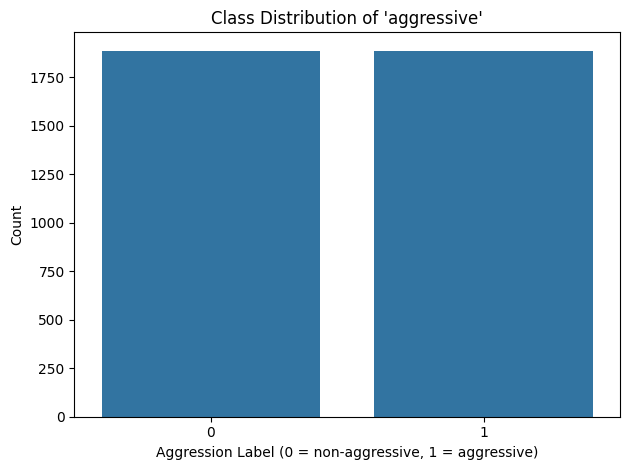

In [22]:
# Plot class distribution for 'aggressive'
sns.countplot(x="aggressive", data=df)
plt.title("Class Distribution of 'aggressive'")
plt.xlabel("Aggression Label (0 = non-aggressive, 1 = aggressive)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



We compute descriptive statistics (mean, std, quartiles) for each numerical feature grouped by aggression label.

In [23]:
# Descriptive statistics by aggression class for selected features
df.groupby("aggressive")[[
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]].describe().T



aggressive                              0            1
time_to_first_view_sec count  1756.000000  1729.000000
                       mean      0.002603    -0.002644
                       std       1.005025     0.995445
                       min      -1.086567    -1.086567
                       25%      -1.081313    -1.080592
                       50%       0.128237     0.134893
                       75%       0.620814     0.667410
                       max       2.235005     2.238333
time_viewed_sec        count  1888.000000  1888.000000
                       mean      0.003163    -0.003163
                       std       1.016375     0.983881
                       min      -0.786230    -0.786230
                       25%      -0.782546    -0.782486
                       50%      -0.780627    -0.779840
                       75%       0.952526     0.846539
                       max       2.075413     2.075413
time_viewed_percent    count  1888.000000  1888.000000
                       mean      0.007000    -0.007000
                       std       0.951955     1.046300
                       min      -1.044461    -1.044461
                       25%      -0.448127    -0.522849
                       50%      -0.047026    -0.104814
                       75%       0.393596     0.383957
                       max      26.396605    27.235415
fixations              count  1888.000000  1888.000000
                       mean      0.019586    -0.019586
                       std       0.976828     1.022790
                       min      -1.714784    -1.714784
                       25%      -0.829068    -0.829068
                       50%       0.056647     0.056647
                       75%       0.499505     0.499505
                       max       4.042368     4.042368
revisits               count  1888.000000  1888.000000
                       mean     -0.022246     0.022246
                       std       0.962439     1.036234
                       min      -0.804328    -0.804328
                       25%      -0.804328    -0.804328
                       50%      -0.804328    -0.804328
                       75%       0.508179     0.508179
                       max       7.070716     5.758208

The following heatmap shows Pearson correlations between the selected eye-tracking features.

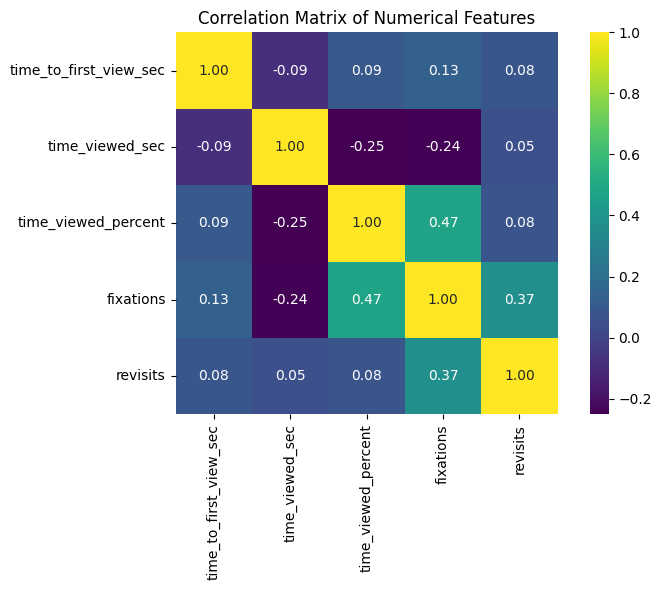

In [24]:
# Define numeric features to include in correlation analysis
numeric_cols = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".2f", square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


We visualize how each eye-tracking feature varies between aggressive and non-aggressive groups using boxplots.

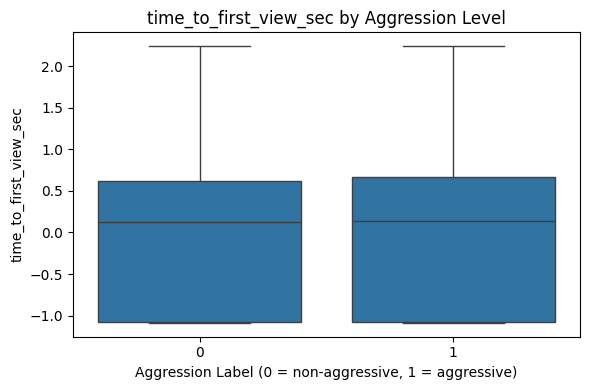

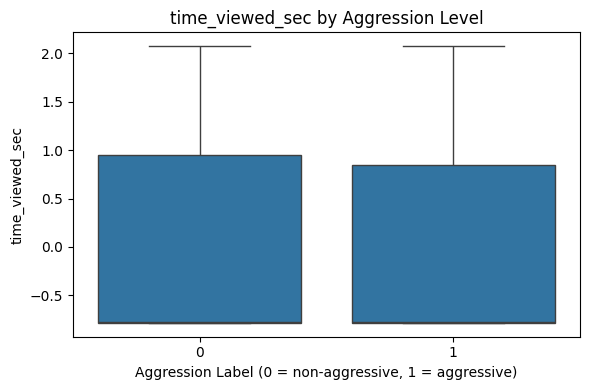

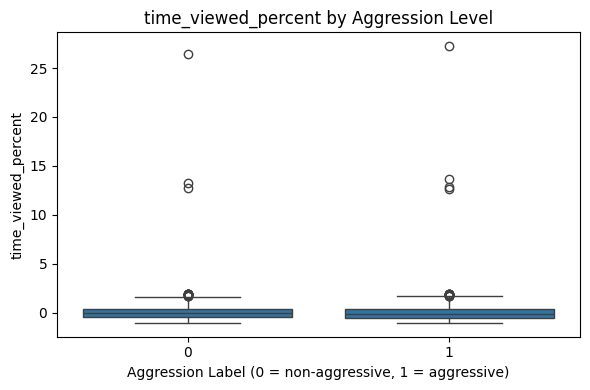

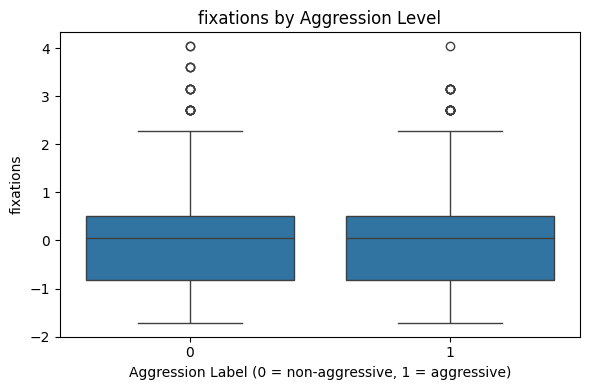

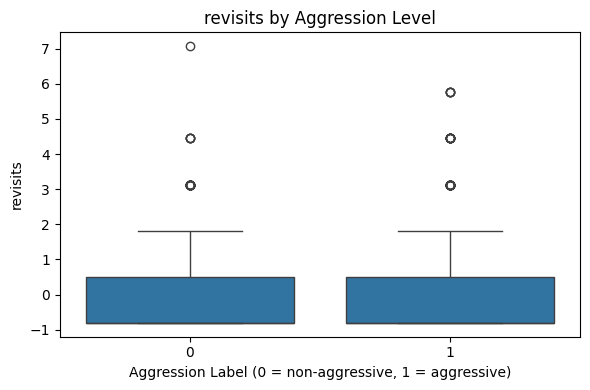

In [25]:
# Define features to visualize
features = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

# Generate boxplots by aggression class
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="aggressive", y=feature, data=df)
    plt.title(f"{feature} by Aggression Level")
    plt.xlabel("Aggression Label (0 = non-aggressive, 1 = aggressive)")
    plt.tight_layout()
    plt.show()



We print detailed statistics (count, mean, std, quartiles) for each numerical feature, grouped by aggression label.

In [26]:
# Print selected descriptive statistics for each feature grouped by aggression label
features = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

for feature in features:
    print(f"\n--- {feature.upper()} ---")
    stats = df.groupby("aggressive")[feature].describe()[["count", "mean", "std", "25%", "50%", "75%"]]
    print(stats)




--- TIME_TO_FIRST_VIEW_SEC ---
             count      mean       std       25%       50%       75%
aggressive                                                          
0           1756.0  0.002603  1.005025 -1.081313  0.128237  0.620814
1           1729.0 -0.002644  0.995445 -1.080592  0.134893  0.667410

--- TIME_VIEWED_SEC ---
             count      mean       std       25%       50%       75%
aggressive                                                          
0           1888.0  0.003163  1.016375 -0.782546 -0.780627  0.952526
1           1888.0 -0.003163  0.983881 -0.782486 -0.779840  0.846539

--- TIME_VIEWED_PERCENT ---
             count   mean       std       25%       50%       75%
aggressive                                                       
0           1888.0  0.007  0.951955 -0.448127 -0.047026  0.393596
1           1888.0 -0.007  1.046300 -0.522849 -0.104814  0.383957

--- FIXATIONS ---
             count      mean       std       25%       50%       75%
aggressive

We visualize all numerical features side by side to identify outliers and differences in scale or distribution.

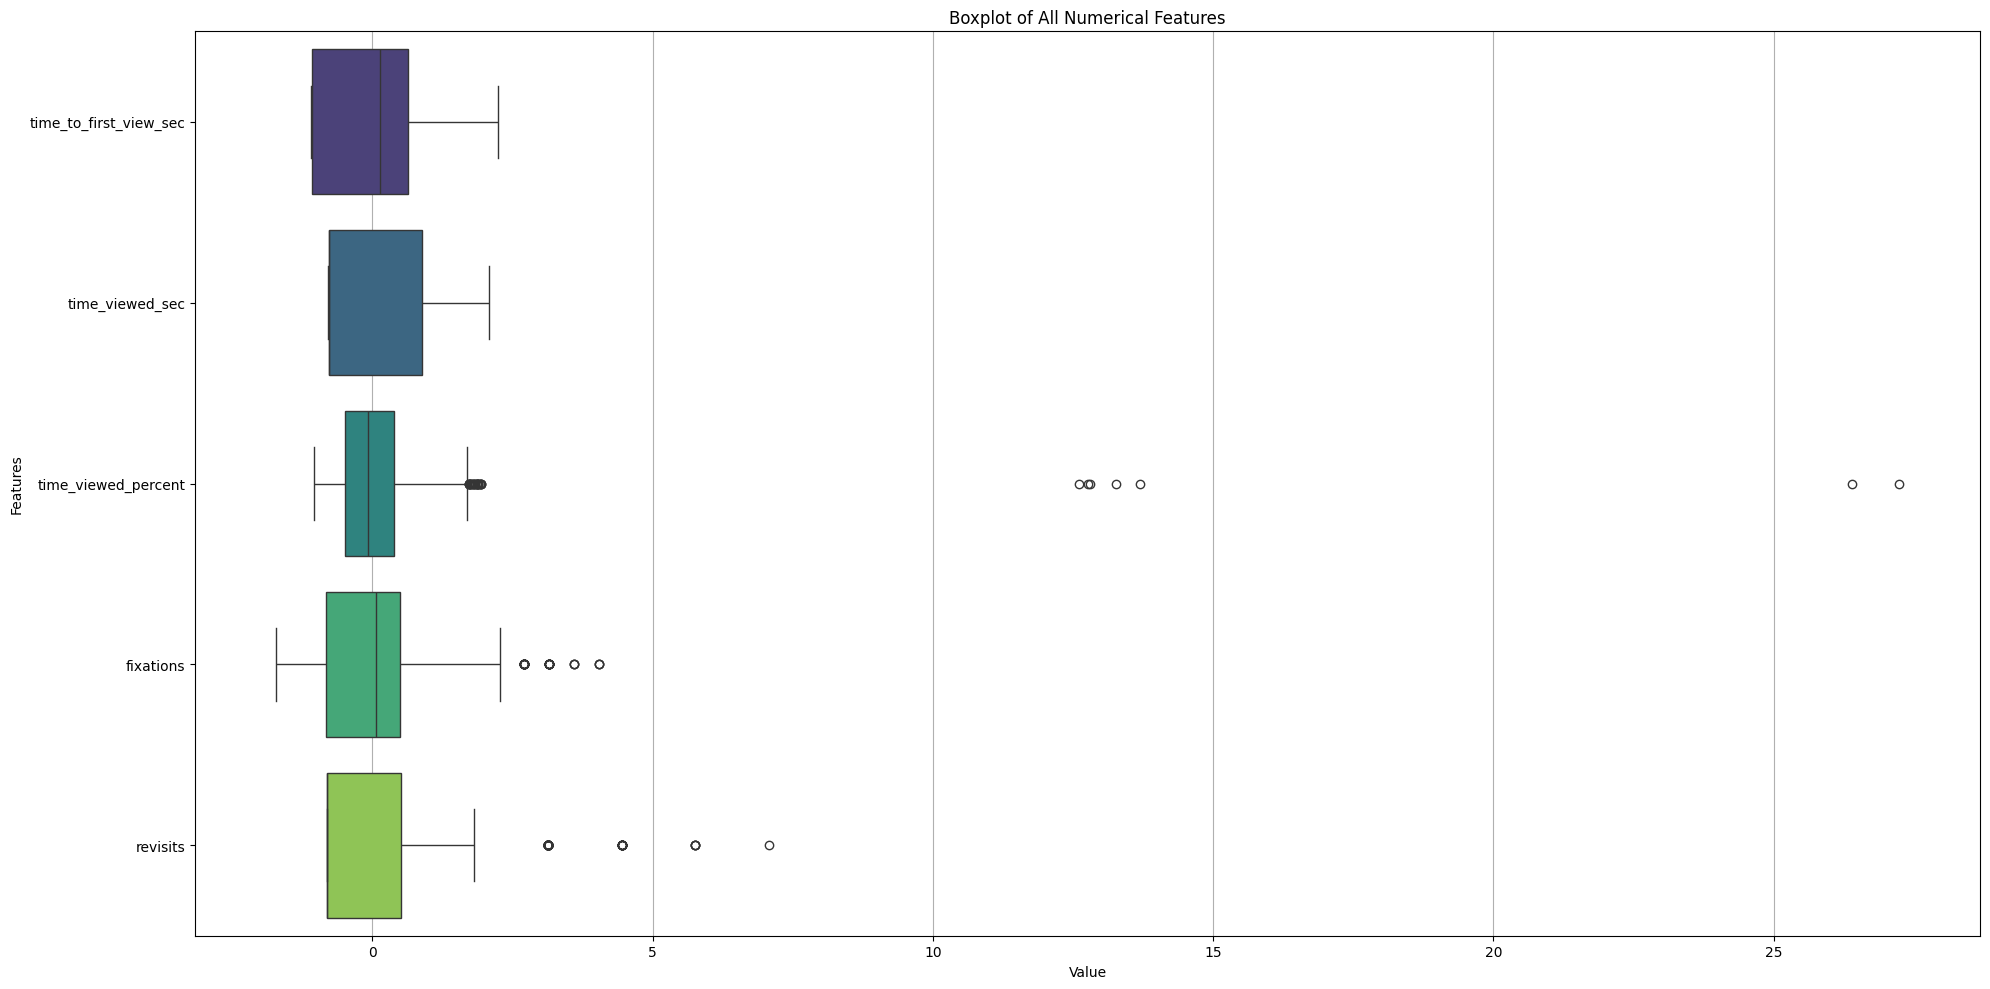

In [27]:
# Boxplot of all numerical features
features = [
    "time_to_first_view_sec",
    "time_viewed_sec",
    "time_viewed_percent",
    "fixations",
    "revisits"
]

plt.figure(figsize=(20, 10))
sns.boxplot(data=df[features], orient="h", palette="viridis")
plt.title("Boxplot of All Numerical Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


# **4. Supervised Modeling – Feature Sets**
We prepare five different feature sets for supervised learning experiments:

1. **All features** (raw, no balancing)
2. **All features + Gaussian noise**
3. **PCA-reduced features** (95% explained variance)
4. **Top 5 most important features** (via Random Forest)
5. **Top 5 features + Gaussian noise**

In [28]:
# === Helper: Add Gaussian noise to features ===
def add_gaussian_noise(X, mean=0.0, std=0.01, random_state=42):
    np.random.seed(random_state)
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

# === Encode categorical variables ===
df_encoded = df.copy()
for col in ["media_name", "aoi_name", "user_gender"]:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# === Impute missing values (mean imputation) ===
imputer = SimpleImputer(strategy="mean")
X_full = df_encoded.drop("aggressive", axis=1)
y_full = df_encoded["aggressive"]
X_imputed = imputer.fit_transform(X_full)

# === Model 1: All features, no modifications ===
X1 = X_imputed
y1 = y_full

# === Model 2: All features + Gaussian noise ===
X2 = add_gaussian_noise(X1)
y2 = y1

# === Model 3: PCA-reduced features (95% variance) ===
pca = PCA(n_components=0.95, random_state=42)
X3 = pca.fit_transform(X1)
y3 = y1

# === Model 4: Top 5 important features via Random Forest ===
rf = RandomForestClassifier(random_state=42)
rf.fit(X1, y1)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_full.columns[indices[:5]]

X4 = pd.DataFrame(X1, columns=X_full.columns)[top_features]
y4 = y1

# === Model 5: Top 5 features + Gaussian noise ===
X5_base = pd.DataFrame(X1, columns=X_full.columns)[top_features]
X5 = add_gaussian_noise(X5_base)
y5 = y1



# **5. Supervised Models**

In this section, we evaluate the performance of several supervised machine learning models for aggression classification.  
We report classification metrics including precision, recall, F1-score, and the confusion matrix for each experiment.


In [30]:
# Dictionary of dataset variants used across all models
models = {
    "Model 1 - Original": (X1, y1),
    "Model 2 - Gaussian Noise": (X2, y2),
    "Model 3 - PCA": (X3, y3),
    "Model 4 - Feature Selection": (X4, y4),
    "Model 5 - Feature Selection + Gaussian Noise": (X5, y5)
}


Logistic regression

In [32]:
# Logistic Regression for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))




=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.599     0.550     0.574       378
           1      0.584     0.632     0.607       378

    accuracy                          0.591       756
   macro avg      0.592     0.591     0.591       756
weighted avg      0.592     0.591     0.591       756

Confusion Matrix:
[[208 170]
 [139 239]]

=== Model 2 - Gaussian Noise ===
Classification Report:
              precision    recall  f1-score   support

           0      0.598     0.550     0.573       378
           1      0.583     0.630     0.606       378

    accuracy                          0.590       756
   macro avg      0.591     0.590     0.589       756
weighted avg      0.591     0.590     0.589       756

Confusion Matrix:
[[208 170]
 [140 238]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.589     0.579     0.584       378
 

Naive Bayes

In [33]:
# Gaussian Naive Bayes for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.617     0.672     0.643       378
           1      0.640     0.582     0.609       378

    accuracy                          0.627       756
   macro avg      0.628     0.627     0.626       756
weighted avg      0.628     0.627     0.626       756

Confusion Matrix:
[[254 124]
 [158 220]]

=== Model 2 - Gaussian Noise ===
Classification Report:
              precision    recall  f1-score   support

           0      0.618     0.672     0.644       378
           1      0.641     0.585     0.611       378

    accuracy                          0.628       756
   macro avg      0.629     0.628     0.628       756
weighted avg      0.629     0.628     0.628       756

Confusion Matrix:
[[254 124]
 [157 221]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.597     0.521     0.556       378
 

Decision tree

In [34]:
# Decision Tree Classifier for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))




=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.951     0.974     0.962       378
           1      0.973     0.950     0.961       378

    accuracy                          0.962       756
   macro avg      0.962     0.962     0.962       756
weighted avg      0.962     0.962     0.962       756

Confusion Matrix:
[[368  10]
 [ 19 359]]

=== Model 2 - Gaussian Noise ===
Classification Report:
              precision    recall  f1-score   support

           0      0.941     0.968     0.954       378
           1      0.967     0.939     0.953       378

    accuracy                          0.954       756
   macro avg      0.954     0.954     0.954       756
weighted avg      0.954     0.954     0.954       756

Confusion Matrix:
[[366  12]
 [ 23 355]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.756     0.772     0.764       378
 

Random forest

In [35]:
# Random Forest Classifier for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.784     0.796     0.790       378
           1      0.793     0.780     0.787       378

    accuracy                          0.788       756
   macro avg      0.788     0.788     0.788       756
weighted avg      0.788     0.788     0.788       756

Confusion Matrix:
[[301  77]
 [ 83 295]]

=== Model 2 - Gaussian Noise ===
Classification Report:
              precision    recall  f1-score   support

           0      0.779     0.812     0.795       378
           1      0.804     0.770     0.786       378

    accuracy                          0.791       756
   macro avg      0.792     0.791     0.791       756
weighted avg      0.792     0.791     0.791       756

Confusion Matrix:
[[307  71]
 [ 87 291]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.617     0.648     0.632       378
 

Support vector machine

In [36]:
# Support Vector Machine (SVM) for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = SVC(kernel="rbf", probability=True, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))




=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.620     0.484     0.544       378
           1      0.577     0.704     0.634       378

    accuracy                          0.594       756
   macro avg      0.599     0.594     0.589       756
weighted avg      0.599     0.594     0.589       756

Confusion Matrix:
[[183 195]
 [112 266]]

=== Model 2 - Gaussian Noise ===
Classification Report:
              precision    recall  f1-score   support

           0      0.620     0.484     0.544       378
           1      0.577     0.704     0.634       378

    accuracy                          0.594       756
   macro avg      0.599     0.594     0.589       756
weighted avg      0.599     0.594     0.589       756

Confusion Matrix:
[[183 195]
 [112 266]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.592     0.495     0.539       378
 

Multilayer perceptron

In [37]:

# Multilayer Perceptron (MLP) for each dataset version
for name, (X, y) in models.items():
    print(f"\n=== {name} ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))




=== Model 1 - Original ===
Classification Report:
              precision    recall  f1-score   support

           0      0.678     0.434     0.529       378
           1      0.584     0.794     0.673       378

    accuracy                          0.614       756
   macro avg      0.631     0.614     0.601       756
weighted avg      0.631     0.614     0.601       756

Confusion Matrix:
[[164 214]
 [ 78 300]]

=== Model 2 - Gaussian Noise ===
Classification Report:
              precision    recall  f1-score   support

           0      0.673     0.442     0.534       378
           1      0.585     0.786     0.670       378

    accuracy                          0.614       756
   macro avg      0.629     0.614     0.602       756
weighted avg      0.629     0.614     0.602       756

Confusion Matrix:
[[167 211]
 [ 81 297]]

=== Model 3 - PCA ===
Classification Report:
              precision    recall  f1-score   support

           0      0.562     0.624     0.591       378
 

# **6 Additional Supervised Models**
In this section, we implement and evaluate three ensemble-based machine learning classifiers:
- **CatBoost Classifier**
- **Stacking Classifier**
- **Voting Classifier** (Hard and Soft)


Performance metrics include:
- Accuracy
- Precision (macro & weighted)
- Recall (macro & weighted)
- F1-score (macro & weighted)
- ROC AUC
- Confusion Matrix

All models use a consistent 80/20 train-test split and `random_state=42` for reproducibility.

**CATBOOST**

In [38]:
results = []

for name, (X, y) in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        l2_leaf_reg=3,
        verbose=0,
        random_state=42
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_macro": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred, average='macro'),
        "Recall_weighted": recall_score(y_test, y_pred, average='weighted'),
        "F1_macro": f1_score(y_test, y_pred, average='macro'),
        "F1_weighted": f1_score(y_test, y_pred, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred).tolist()
    })

df_catboost_results = pd.DataFrame(results)
print(df_catboost_results)



                                          Model  Accuracy  Precision_macro  \
0                            Model 1 - Original  0.988095         0.988181   
1                      Model 2 - Gaussian Noise  0.943122         0.943125   
2                                 Model 3 - PCA  0.757937         0.758083   
3                   Model 4 - Feature Selection  0.933862         0.933875   
4  Model 5 - Feature Selection + Gaussian Noise  0.904762         0.905318   

   Precision_weighted  Recall_macro  Recall_weighted  F1_macro  F1_weighted  \
0            0.988181      0.988095         0.988095  0.988095     0.988095   
1            0.943125      0.943122         0.943122  0.943122     0.943122   
2            0.758083      0.757937         0.757937  0.757902     0.757902   
3            0.933875      0.933862         0.933862  0.933862     0.933862   
4            0.905318      0.904762         0.904762  0.904729     0.904729   

        AUC        Confusion_Matrix  
0  0.999713    [[3

**STACKING CLASSIFIER**

In [39]:
results = []

for name, (X, y) in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    base_models = [
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ]

    meta_model = CatBoostClassifier(
        iterations=500, learning_rate=0.1, depth=6,
        l2_leaf_reg=3, verbose=0, random_state=42
    )

    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5
    )
    stacking_clf.fit(X_train, y_train)

    y_pred = stacking_clf.predict(X_test)
    y_prob = stacking_clf.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_macro": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred, average='macro'),
        "Recall_weighted": recall_score(y_test, y_pred, average='weighted'),
        "F1_macro": f1_score(y_test, y_pred, average='macro'),
        "F1_weighted": f1_score(y_test, y_pred, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred).tolist()
    })

df_stacking_results = pd.DataFrame(results)
print(df_stacking_results)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

                                          Model  Accuracy  Precision_macro  \
0                            Model 1 - Original  0.767196         0.767196   
1                      Model 2 - Gaussian Noise  0.769841         0.770326   
2                                 Model 3 - PCA  0.637566         0.637755   
3                   Model 4 - Feature Selection  0.789683         0.789733   
4  Model 5 - Feature Selection + Gaussian Noise  0.822751         0.823485   

   Precision_weighted  Recall_macro  Recall_weighted  F1_macro  F1_weighted  \
0            0.767196      0.767196         0.767196  0.767196     0.767196   
1            0.770326      0.769841         0.769841  0.769738     0.769738   
2            0.637755      0.637566         0.637566  0.637442     0.637442   
3            0.789733      0.789683         0.789683  0.789673     0.789673   
4            0.823485      0.822751         0.822751  0.822651     0.822651   

        AUC          Confusion_Matrix  
0  0.850365    [

**VOTING CLASSIFIER**

In [40]:
results_hard = []
results_soft = []

for name, (X, y) in models.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    svm_model = SVC(probability=True, random_state=42)
    xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
    gb_model = GradientBoostingClassifier(random_state=42)
    rf_model = RandomForestClassifier(random_state=42)

    hard_voting_clf = VotingClassifier(estimators=[
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('gb', gb_model),
        ('rf', rf_model)
    ], voting='hard')

    soft_voting_clf = VotingClassifier(estimators=[
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('gb', gb_model),
        ('rf', rf_model)
    ], voting='soft')

    hard_voting_clf.fit(X_train, y_train)
    soft_voting_clf.fit(X_train, y_train)

    y_pred_hard = hard_voting_clf.predict(X_test)
    y_pred_soft = soft_voting_clf.predict(X_test)

    rf_model.fit(X_train, y_train)
    y_prob_hard = rf_model.predict_proba(X_test)[:, 1]
    y_prob_soft = soft_voting_clf.predict_proba(X_test)[:, 1]

    results_hard.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_hard),
        "Precision_macro": precision_score(y_test, y_pred_hard, average='macro', zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred_hard, average='weighted', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred_hard, average='macro'),
        "Recall_weighted": recall_score(y_test, y_pred_hard, average='weighted'),
        "F1_macro": f1_score(y_test, y_pred_hard, average='macro'),
        "F1_weighted": f1_score(y_test, y_pred_hard, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob_hard),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred_hard).tolist()
    })

    results_soft.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_soft),
        "Precision_macro": precision_score(y_test, y_pred_soft, average='macro', zero_division=0),
        "Precision_weighted": precision_score(y_test, y_pred_soft, average='weighted', zero_division=0),
        "Recall_macro": recall_score(y_test, y_pred_soft, average='macro'),
        "Recall_weighted": recall_score(y_test, y_pred_soft, average='weighted'),
        "F1_macro": f1_score(y_test, y_pred_soft, average='macro'),
        "F1_weighted": f1_score(y_test, y_pred_soft, average='weighted'),
        "AUC": roc_auc_score(y_test, y_prob_soft),
        "Confusion_Matrix": confusion_matrix(y_test, y_pred_soft).tolist()
    })

df_results_hard = pd.DataFrame(results_hard)
df_results_soft = pd.DataFrame(results_soft)

print("Hard Voting Results:")
print(df_results_hard.sort_values(by="F1_weighted", ascending=False))

print("\nSoft Voting Results:")
print(df_results_soft.sort_values(by="F1_weighted", ascending=False))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:38:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:38:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:38:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:38:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:38:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Hard Voting Results:
                                          Model  Accuracy  Precision_macro  \
0                            Model 1 - Original  0.906085         0.915533   
3                   Model 4 - Feature Selection  0.875661         0.880821   
4  Model 5 - Feature Selection + Gaussian Noise  0.865079         0.870567   
1                      Model 2 - Gaussian Noise  0.854497         0.863045   
2                                 Model 3 - PCA  0.662698         0.663662   

   Precision_weighted  Recall_macro  Recall_weighted  F1_macro  F1_weighted  \
0            0.915533      0.906085         0.906085  0.905548     0.905548   
3            0.880821      0.875661         0.875661  0.875239     0.875239   
4            0.870567      0.865079         0.865079  0.864578     0.864578   
1            0.863045      0.854497         0.854497  0.853636     0.853636   
2            0.663662      0.662698         0.662698  0.662201     0.662201   

        AUC          Confusion_Matr

# **7. Unsupervised Models**

In this section, we apply and evaluate multiple unsupervised clustering algorithms on eye-tracking data for aggression profiling:

- **K-Means (with PCA and t-SNE projections)**
- **DBSCAN (2D and 3D via t-SNE)**
- **Gaussian Mixture Models (GMM with 2 and 3 components)**

The data is preprocessed by:
- Encoding categorical variables
- Imputing missing values with the mean
- Optionally scaling the features for algorithms sensitive to scale

Performance is evaluated using the following clustering metrics:

- **Adjusted Rand Index (ARI)**
- **Silhouette Score**
- **Normalized Mutual Information (NMI)**

Visualizations are included for both 2D and 3D projections to interpret clustering quality.

In [42]:
# Load uploaded CSV
df = pd.read_csv("ET_EmoAgg_Youth_Tab_NO_NEUTRAL_SCALED.csv")

y_true = df["aggressive"]
X_unsupervised = df.drop(columns=["aggressive"])

print("X_unsupervised shape:", X_unsupervised.shape)
print("Unique labels in y_true:", y_true.unique())


X_unsupervised shape: (3776, 11)
Unique labels in y_true: [1 0]


We create a copy of the feature matrix and encode all categorical features using `LabelEncoder` to prepare for clustering.


In [43]:
X_clean = X_unsupervised.copy()
for col in X_clean.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_clean[col] = le.fit_transform(X_clean[col])


In [44]:
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_clean)

**K-Means**

KMeans + PCA results:
ARI: 0.0149
Silhouette Score: 0.3661
NMI: 0.0173


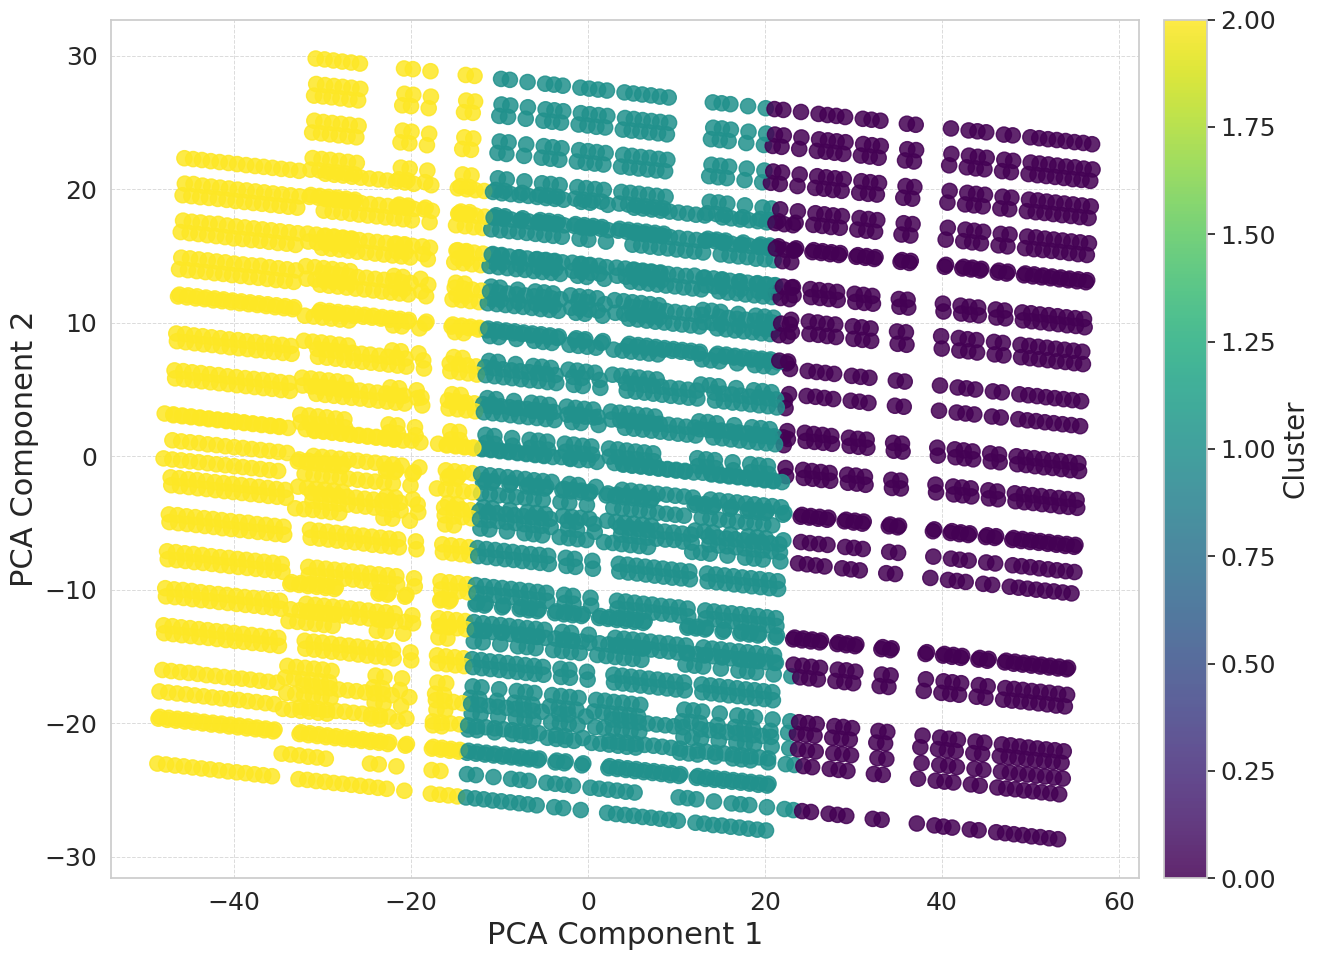

In [45]:
# Plot settings
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})

# PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_imputed)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Metrics
ari = adjusted_rand_score(y_true, cluster_labels)
silhouette = silhouette_score(X_pca, cluster_labels)
nmi = normalized_mutual_info_score(y_true, cluster_labels)

print("KMeans + PCA results:")
print(f"ARI: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"NMI: {nmi:.4f}")

# Visualization
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=cluster_labels, cmap='viridis',
    s=120, alpha=0.85
)

plt.xlabel("PCA Component 1", fontsize=22)
plt.ylabel("PCA Component 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label("Cluster", fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()


TSNE+K-MEANS

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KMeans + t-SNE results:
ARI: 0.0053
Silhouette Score: 0.3857
NMI: 0.0050


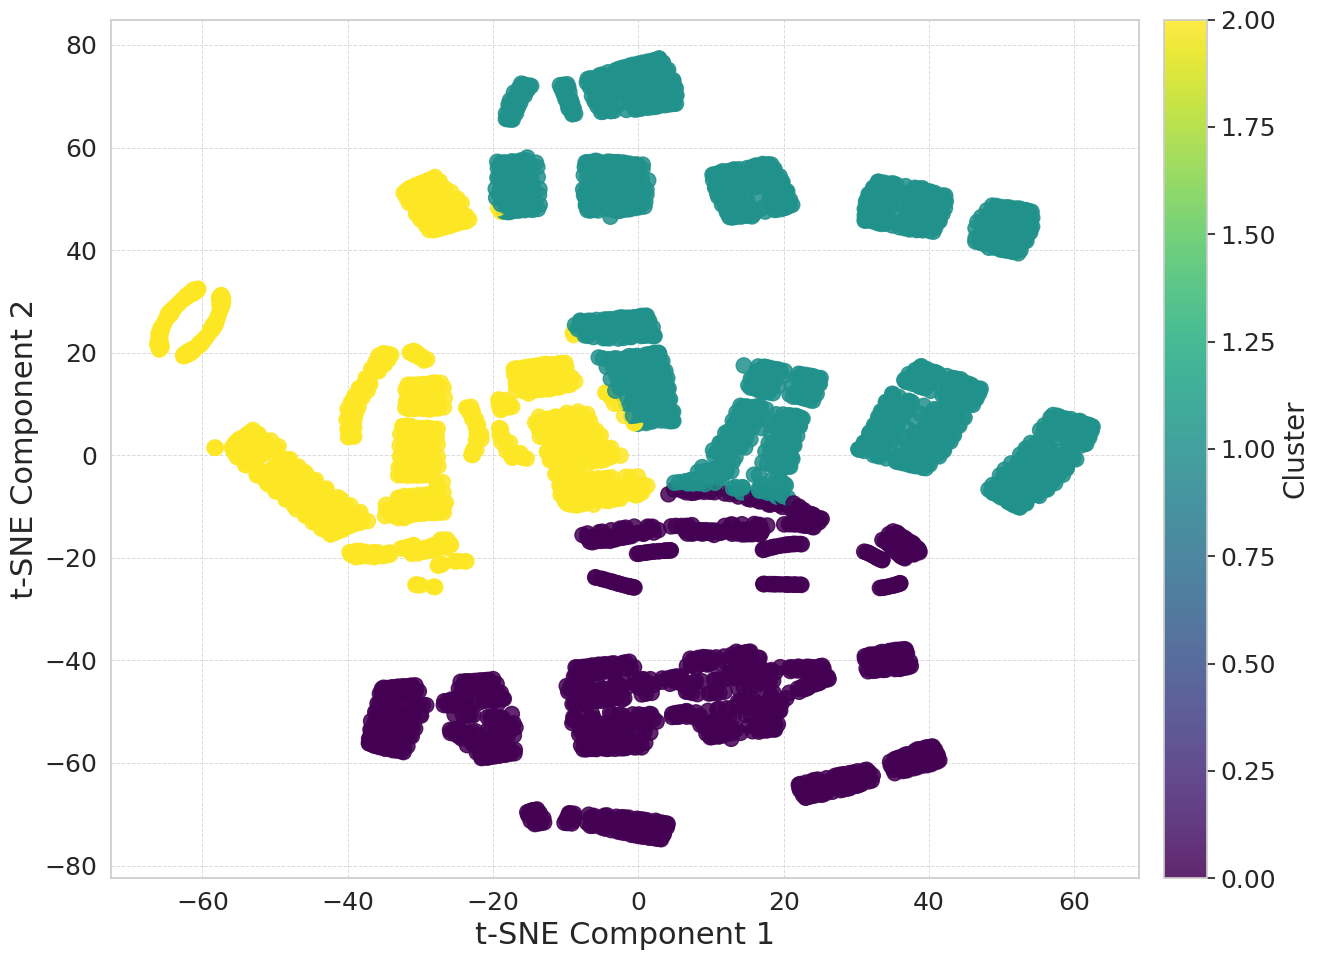

In [46]:

# Plot settings
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_imputed)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_tsne)

# Metrics
ari = adjusted_rand_score(y_true, cluster_labels)
silhouette = silhouette_score(X_tsne, cluster_labels)
nmi = normalized_mutual_info_score(y_true, cluster_labels)

print("KMeans + t-SNE results:")
print(f"ARI: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"NMI: {nmi:.4f}")

# Visualization
palette = sns.color_palette("muted", n_colors=3)
cmap_continuo = LinearSegmentedColormap.from_list("muted_continuous", palette.as_hex())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=120, alpha=0.85
)

plt.xlabel("t-SNE Component 1", fontsize=22)
plt.ylabel("t-SNE Component 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label("Cluster", fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


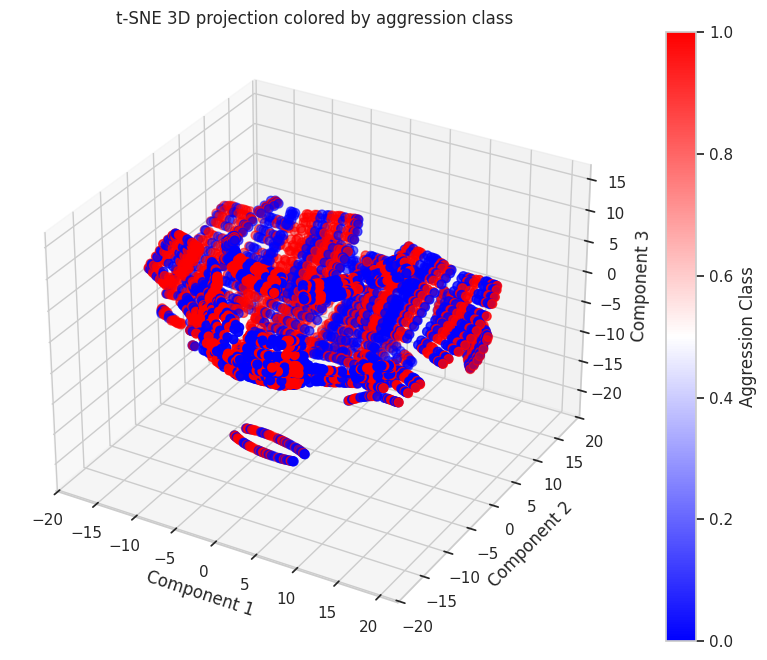

In [47]:
# 3D t-SNE projection
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_imputed)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
    c=y_true.astype(int), cmap='bwr', s=40
)

ax.set_title("t-SNE 3D projection colored by aggression class")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

plt.colorbar(sc, label="Aggression Class")
plt.tight_layout()
plt.show()


DBSCAN

DBSCAN on t-SNE 2D:
ARI: 0.0017
Silhouette: 0.3022
NMI: 0.0069
Unique clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)}


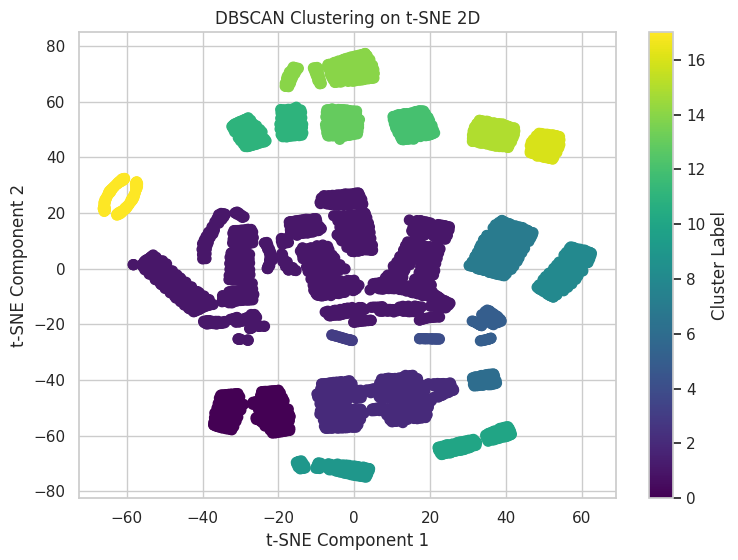

In [48]:
# DBSCAN clustering on 2D t-SNE
dbscan_2d = DBSCAN(eps=5, min_samples=5)
labels_2d = dbscan_2d.fit_predict(X_tsne)

# Evaluation metrics
ari_2d = adjusted_rand_score(y_true, labels_2d)
silhouette_2d = silhouette_score(X_tsne, labels_2d) if len(set(labels_2d)) > 1 else -1
nmi_2d = normalized_mutual_info_score(y_true, labels_2d)

print("DBSCAN on t-SNE 2D:")
print(f"ARI: {ari_2d:.4f}")
print(f"Silhouette: {silhouette_2d:.4f}")
print(f"NMI: {nmi_2d:.4f}")
print("Unique clusters:", set(labels_2d))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_2d, cmap='viridis', s=50)
plt.title("DBSCAN Clustering on t-SNE 2D")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster Label")
plt.tight_layout()
plt.show()

DBSCAN on t-SNE 3D:
ARI: -0.0002
Silhouette: 0.2889
NMI: 0.0000
Unique clusters: {np.int64(0), np.int64(1), np.int64(2)}


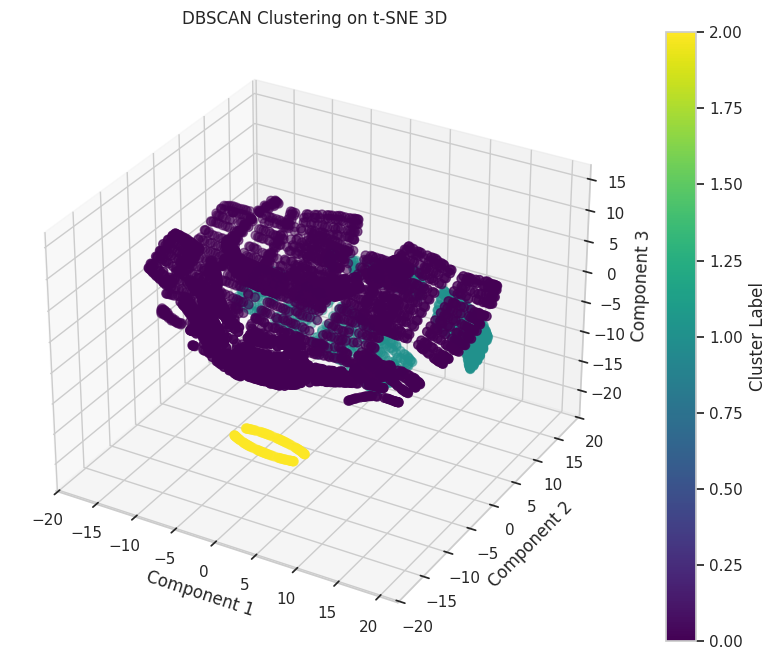

In [49]:
# DBSCAN clustering on 3D t-SNE
dbscan_3d = DBSCAN(eps=5, min_samples=5)
labels_3d = dbscan_3d.fit_predict(X_tsne_3d)

# Evaluation metrics
ari_3d = adjusted_rand_score(y_true, labels_3d)
silhouette_3d = silhouette_score(X_tsne_3d, labels_3d) if len(set(labels_3d)) > 1 else -1
nmi_3d = normalized_mutual_info_score(y_true, labels_3d)

print("DBSCAN on t-SNE 3D:")
print(f"ARI: {ari_3d:.4f}")
print(f"Silhouette: {silhouette_3d:.4f}")
print(f"NMI: {nmi_3d:.4f}")
print("Unique clusters:", set(labels_3d))

# 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=labels_3d, cmap='viridis', s=40)

ax.set_title("DBSCAN Clustering on t-SNE 3D")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.colorbar(sc, label="Cluster Label")
plt.tight_layout()
plt.show()

In [51]:
# Preprocessing and clustering on original feature space
df = pd.read_csv("ET_EmoAgg_Youth_Tab_NO_NEUTRAL_SCALED.csv")

for col in ["media_name", "aoi_name", "user_gender"]:
    df[col] = LabelEncoder().fit_transform(df[col])

y_true = df["aggressive"].values
X = df.drop("aggressive", axis=1)

X_imputed = SimpleImputer(strategy="mean").fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imputed)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# KMeans metrics
kmeans_results = {
    "ARI": adjusted_rand_score(y_true, kmeans_labels),
    "Silhouette": silhouette_score(X_scaled, kmeans_labels),
    "NMI": normalized_mutual_info_score(y_true, kmeans_labels)
}

# DBSCAN metrics
if len(set(dbscan_labels)) > 1:
    dbscan_results = {
        "ARI": adjusted_rand_score(y_true, dbscan_labels),
        "Silhouette": silhouette_score(X_scaled, dbscan_labels),
        "NMI": normalized_mutual_info_score(y_true, dbscan_labels)
    }
else:
    dbscan_results = {
        "ARI": adjusted_rand_score(y_true, dbscan_labels),
        "Silhouette": -1,
        "NMI": normalized_mutual_info_score(y_true, dbscan_labels)
    }

print("KMeans results:", kmeans_results)
print("DBSCAN results:", dbscan_results)



KMeans results: {'ARI': -0.0002543440664919592, 'Silhouette': np.float64(0.18014927020881835), 'NMI': np.float64(7.304905755594464e-06)}
DBSCAN results: {'ARI': 0.0005876991079290583, 'Silhouette': np.float64(-0.020886858681452267), 'NMI': np.float64(0.002434967162755713)}


GMM Results: {'ARI': -0.00015741119796075772, 'Silhouette': np.float64(0.13299622821712118), 'NMI': np.float64(3.7898596778162845e-05)}


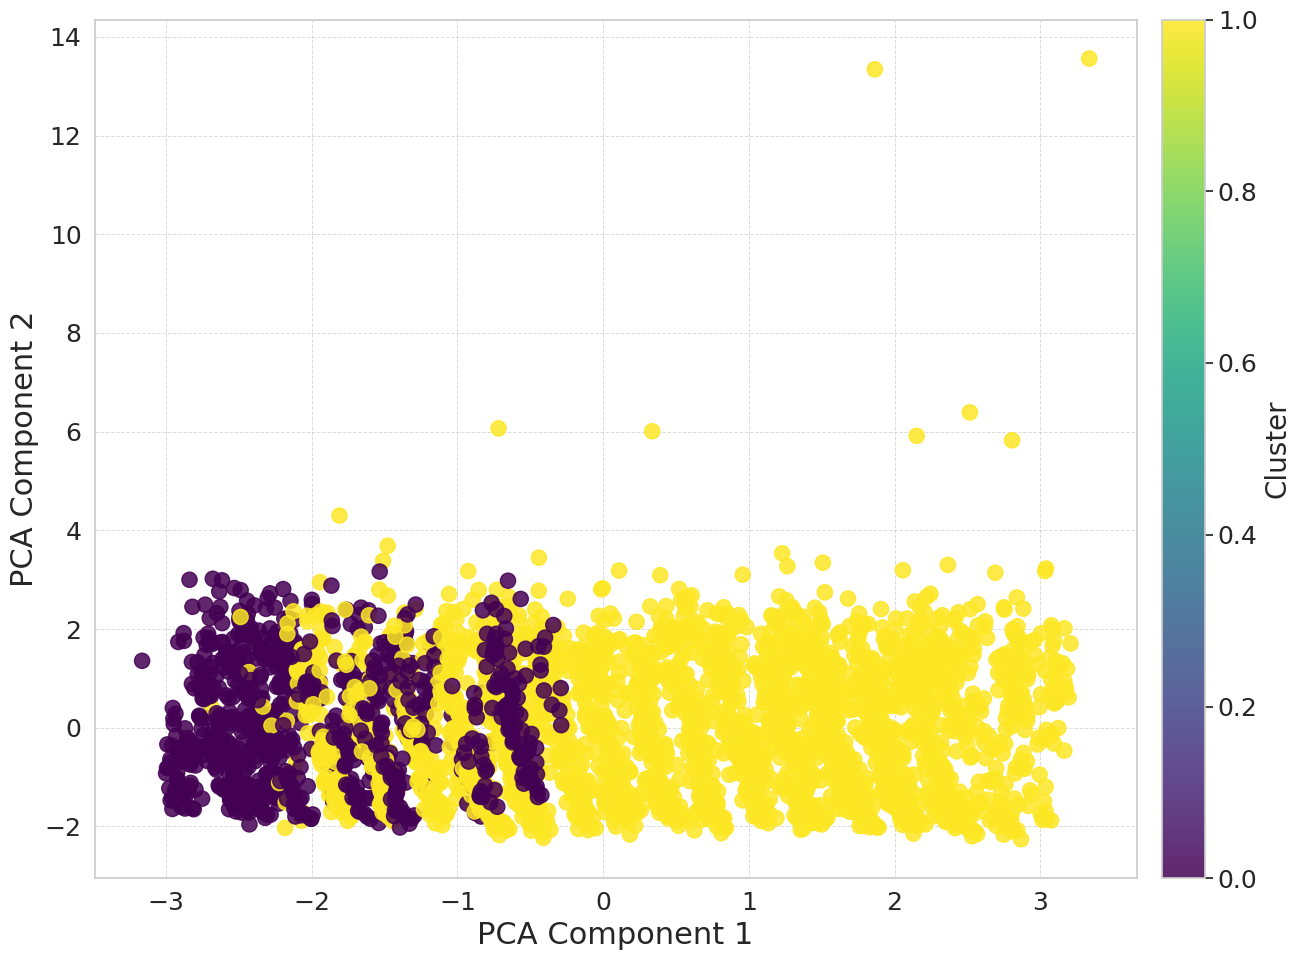

In [52]:
# GMM clustering and PCA visualization (2 components)
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

gmm_metrics = {
    "ARI": adjusted_rand_score(y_true, gmm_labels),
    "Silhouette": silhouette_score(X_scaled, gmm_labels),
    "NMI": normalized_mutual_info_score(y_true, gmm_labels)
}
print("GMM Results:", gmm_metrics)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

palette = sns.color_palette("muted", n_colors=2)
cmap_continuo = LinearSegmentedColormap.from_list("muted_continuous", palette.as_hex())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=gmm_labels,
    cmap='viridis',
    s=120, alpha=0.85
)

plt.xlabel("PCA Component 1", fontsize=22)
plt.ylabel("PCA Component 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label("Cluster", fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

GMM (3 components) Results: {'ARI': 0.00027764602422894474, 'Silhouette': np.float64(0.09298762379670111), 'NMI': np.float64(0.00044979096306136616)}


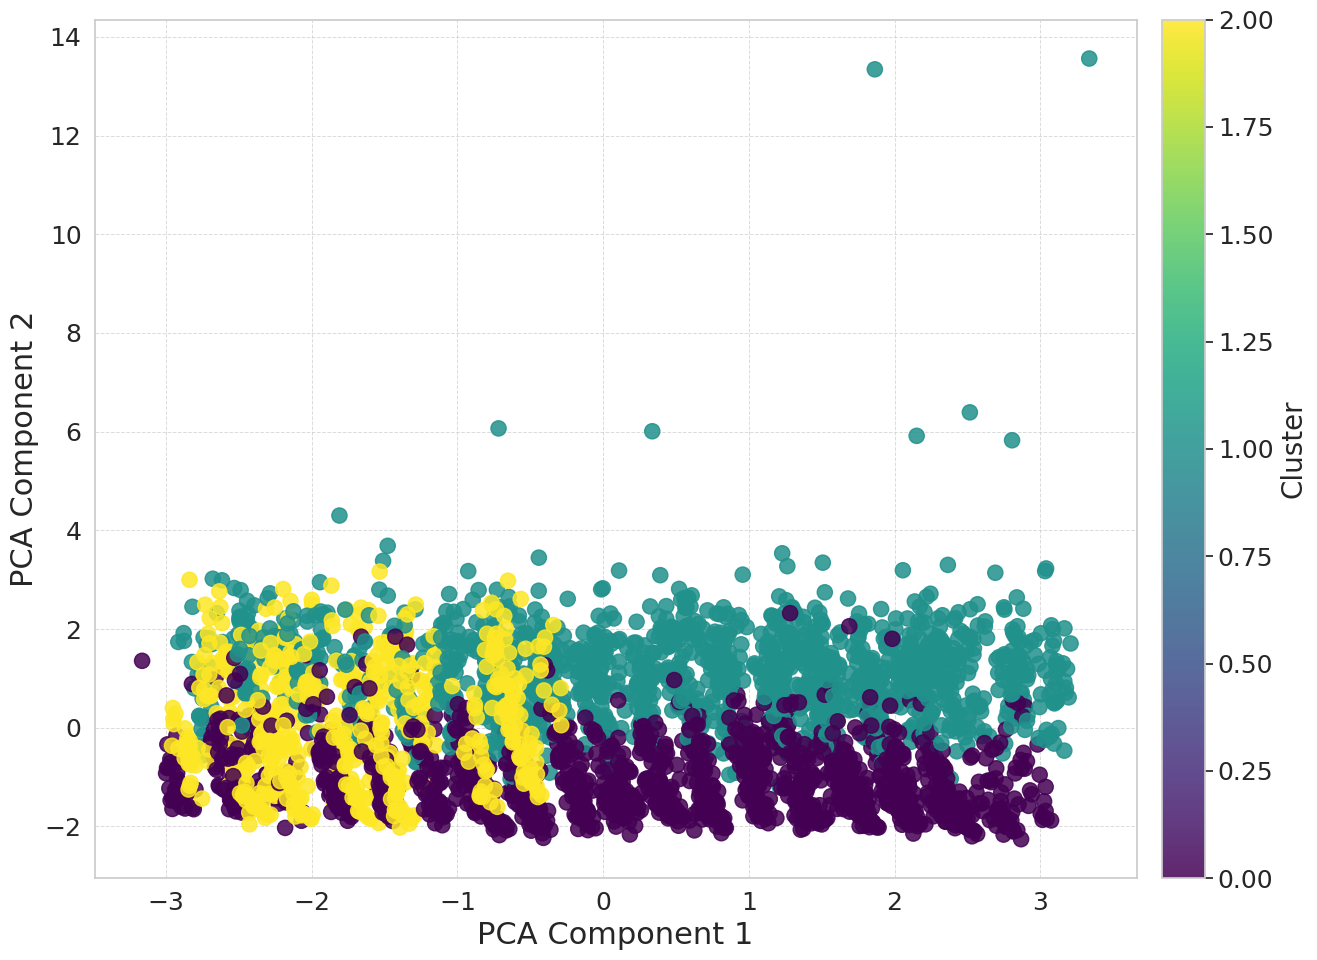

In [53]:
# GMM clustering with 3 components and PCA visualization
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 20})

gmm3 = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_labels_3 = gmm3.fit_predict(X_scaled)

gmm3_metrics = {
    "ARI": adjusted_rand_score(y_true, gmm_labels_3),
    "Silhouette": silhouette_score(X_scaled, gmm_labels_3),
    "NMI": normalized_mutual_info_score(y_true, gmm_labels_3)
}
print("GMM (3 components) Results:", gmm3_metrics)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

palette = sns.color_palette("muted", n_colors=3)
cmap_continuo = LinearSegmentedColormap.from_list("muted_continuous", palette.as_hex())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=gmm_labels_3,
    cmap='viridis',
    s=120, alpha=0.85
)

plt.xlabel("PCA Component 1", fontsize=22)
plt.ylabel("PCA Component 2", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = plt.colorbar(scatter, pad=0.02)
cbar.set_label("Cluster", fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()



# **8. RESULTS**

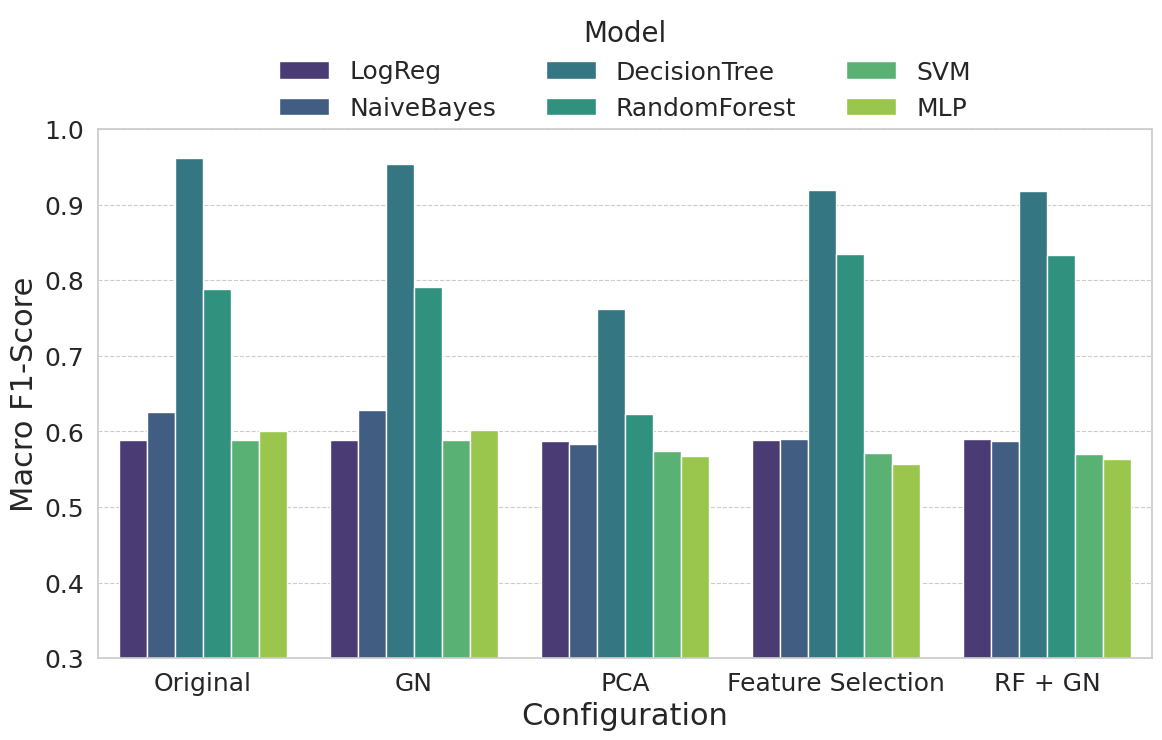

In [54]:
# Prepare data for visualization
models = ['LogReg', 'NaiveBayes', 'DecisionTree', 'RandomForest', 'SVM', 'MLP']
configs = ['Original', 'GN', 'PCA', 'Feature Selection', 'RF + GN']
f1_scores = {
    'LogReg': [0.589, 0.589, 0.587, 0.589, 0.590],
    'NaiveBayes': [0.626, 0.628, 0.583, 0.590, 0.587],
    'DecisionTree': [0.962, 0.954, 0.762, 0.919, 0.918],
    'RandomForest': [0.788, 0.791, 0.623, 0.835, 0.834],
    'SVM': [0.589, 0.589, 0.574, 0.571, 0.570],
    'MLP': [0.601, 0.602, 0.567, 0.557, 0.563],
}

df = pd.DataFrame(f1_scores, index=configs).reset_index().melt(id_vars='index')
df.columns = ['Configuration', 'Model', 'Macro F1-Score']

# Plot
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid', font_scale=1.6)

ax = sns.barplot(
    data=df,
    x='Configuration',
    y='Macro F1-Score',
    hue='Model',
    palette='viridis'
)

ax.set_ylabel('Macro F1-Score', fontsize=22)
ax.set_xlabel('Configuration', fontsize=22)
ax.set_ylim(0.3, 1)
ax.tick_params(axis='x', rotation=0, labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.legend(
    title='Model',
    fontsize=18,
    title_fontsize=20,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=3,
    frameon=False
)

ax.grid(axis='y', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

<ipython-input-55-3831420120>:19: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.lineplot(


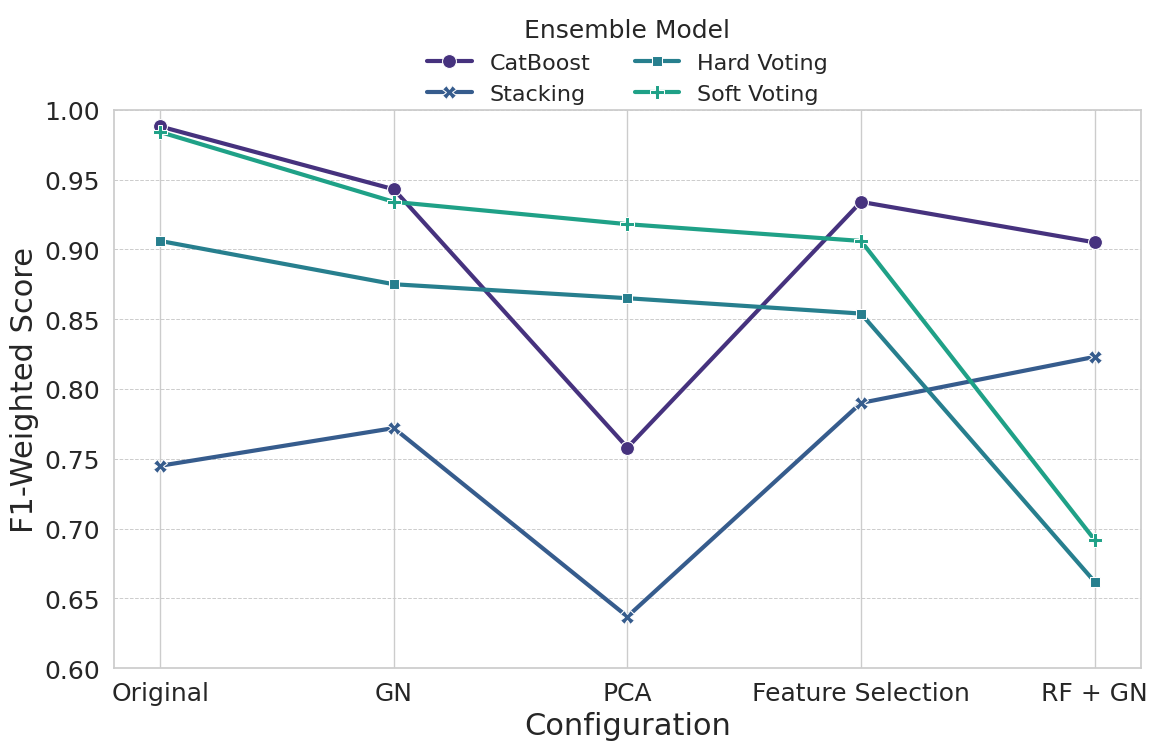

In [55]:
# Data
configs = ['Original', 'GN', 'PCA', 'Feature Selection', 'RF + GN']
f1_weighted = {
    'CatBoost': [0.988, 0.943, 0.758, 0.934, 0.905],
    'Stacking': [0.745, 0.772, 0.637, 0.790, 0.823],
    'Hard Voting': [0.906, 0.875, 0.865, 0.854, 0.662],
    'Soft Voting': [0.984, 0.934, 0.918, 0.906, 0.692],
}

df_f1_college = pd.DataFrame(f1_weighted, index=configs).reset_index().melt(id_vars='index')
df_f1_college.columns = ['Configuration', 'Model', 'F1-Weighted Score']

# Plot
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid', font_scale=1.6)

palette = sns.color_palette('viridis')

ax = sns.lineplot(
    data=df_f1_college,
    x='Configuration',
    y='F1-Weighted Score',
    hue='Model',
    style='Model',
    markers=True,
    dashes=False,
    linewidth=3,
    markersize=10,
    palette=palette
)

# Aesthetics
ax.set_ylabel('F1-Weighted Score', fontsize=22)
ax.set_xlabel('Configuration', fontsize=22)
ax.set_ylim(0.6, 1.0)
ax.tick_params(axis='x', rotation=0, labelsize=18)
ax.tick_params(axis='y', labelsize=18)

# Horizontal legend
ax.legend(
    title='Ensemble Model',
    fontsize=16,
    title_fontsize=18,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.20),
    ncol=2,
    frameon=False
)

ax.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

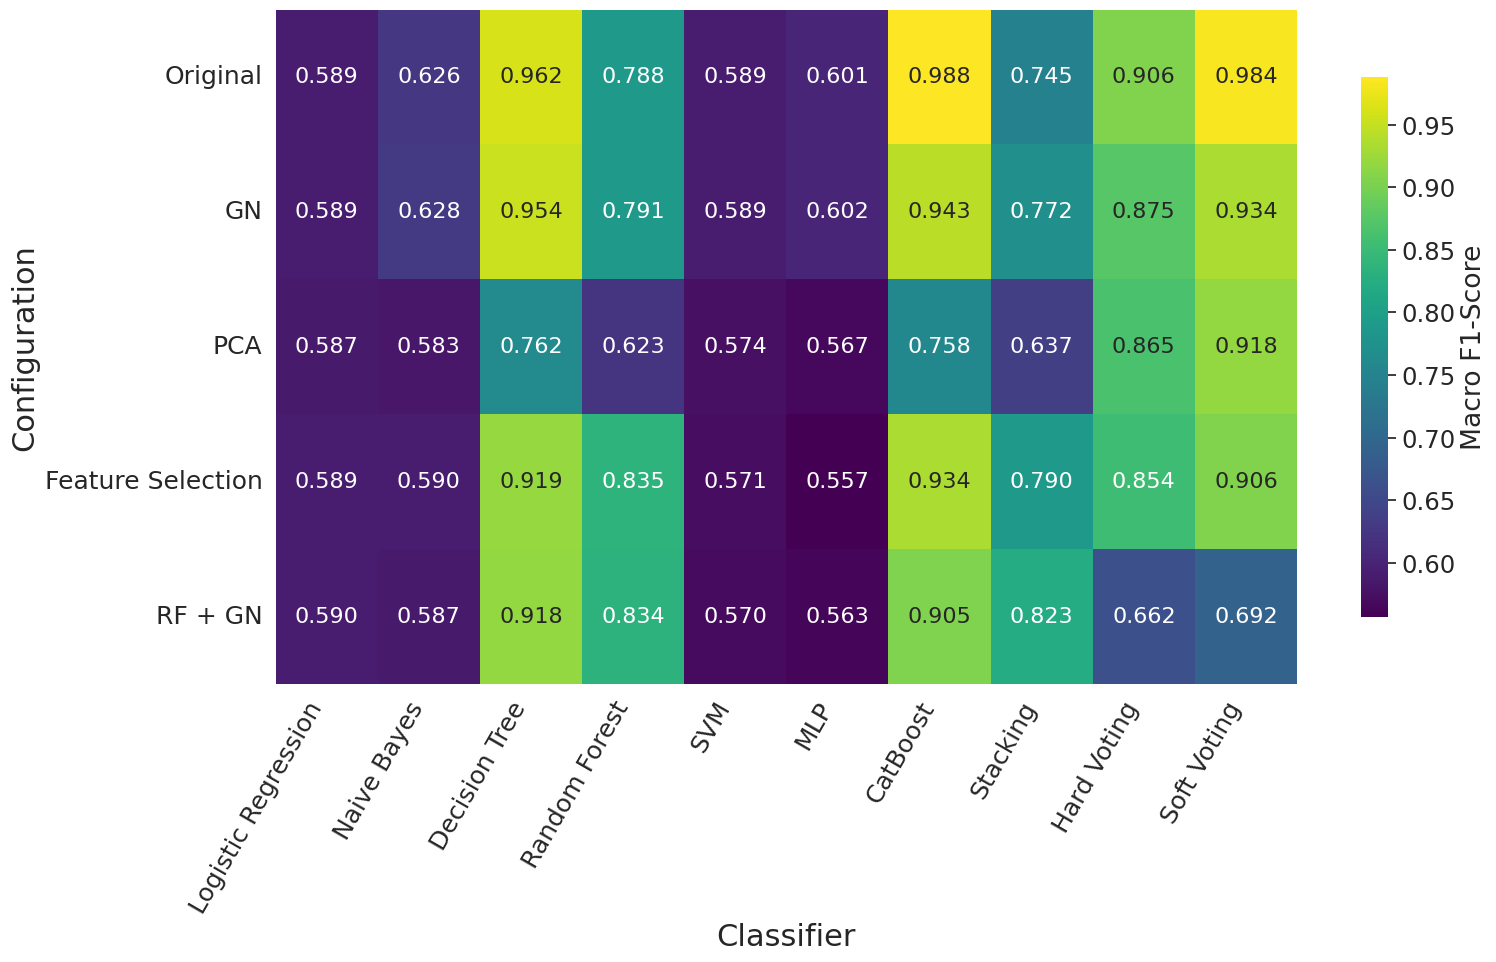

In [56]:
# F1_macro
data = {
    'Original': {
        'Logistic Regression': 0.589,
        'Naive Bayes': 0.626,
        'Decision Tree': 0.962,
        'Random Forest': 0.788,
        'SVM': 0.589,
        'MLP': 0.601,
        'CatBoost': 0.988,
        'Stacking': 0.745,
        'Hard Voting': 0.906,
        'Soft Voting': 0.984,
    },
    'GN': {
        'Logistic Regression': 0.589,
        'Naive Bayes': 0.628,
        'Decision Tree': 0.954,
        'Random Forest': 0.791,
        'SVM': 0.589,
        'MLP': 0.602,
        'CatBoost': 0.943,
        'Stacking': 0.772,
        'Hard Voting': 0.875,
        'Soft Voting': 0.934,
    },
    'PCA': {
        'Logistic Regression': 0.587,
        'Naive Bayes': 0.583,
        'Decision Tree': 0.762,
        'Random Forest': 0.623,
        'SVM': 0.574,
        'MLP': 0.567,
        'CatBoost': 0.758,
        'Stacking': 0.637,
        'Hard Voting': 0.865,
        'Soft Voting': 0.918,
    },
    'Feature Selection': {
        'Logistic Regression': 0.589,
        'Naive Bayes': 0.590,
        'Decision Tree': 0.919,
        'Random Forest': 0.835,
        'SVM': 0.571,
        'MLP': 0.557,
        'CatBoost': 0.934,
        'Stacking': 0.790,
        'Hard Voting': 0.854,
        'Soft Voting': 0.906,
    },
    'RF + GN': {
        'Logistic Regression': 0.590,
        'Naive Bayes': 0.587,
        'Decision Tree': 0.918,
        'Random Forest': 0.834,
        'SVM': 0.570,
        'MLP': 0.563,
        'CatBoost': 0.905,
        'Stacking': 0.823,
        'Hard Voting': 0.662,
        'Soft Voting': 0.692,
    }
}

# DataFrame
df_college = pd.DataFrame(data).T

# Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    df_college,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={'label': 'Macro F1-Score', 'shrink': 0.8},
    annot_kws={"size": 16}
)


plt.xlabel('Classifier', fontsize=22)
plt.ylabel('Configuration', fontsize=22)
plt.xticks(rotation=60, fontsize=18, ha='right')
plt.yticks(rotation=0, fontsize=18)
plt.tight_layout()
plt.show()